# 🧠🤖 Deep Agents with LangGraph

Using an LLM to call tools in a loop is the simplest form of an agent. This architecture, however, can yield agents that are "shallow" and fail to plan and act over longer, more complex tasks. Applications like "Deep Research", "Manus", and "Claude Code" have gotten around this limitation by implementing a combination of four things:

- **Planning tool** - helps agents structure complex tasks
- **Sub agents** - specialized agents for specific tasks  
- **File system** - persistent workspace for intermediate results
- **Detailed prompt** - comprehensive instructions for deep reasoning

This notebook demonstrates the `deepagents` library which implements these patterns in a general purpose way, allowing you to easily create Deep Agents for your applications.

## What Makes an Agent "Deep"?

Deep agents differ from simple tool-calling agents in several key ways:

1. **Planning Capability** - Can break down complex tasks into subtasks
2. **Context Quarantine** - Uses sub-agents to avoid context pollution
3. **Persistent Workspace** - Maintains state across multiple interactions
4. **Specialized Instructions** - Detailed prompts for specific domains

In this exercise, we'll build a deep research agent that can conduct thorough investigations and produce comprehensive reports.

## Installation and Setup

In [2]:
# Install required packages
!uv pip install -qU deepagents tavily-python

In [2]:
import os
from typing import Literal
from tavily import TavilyClient
from deepagents import create_deep_agent

In [3]:
# Set up API keys - you'll need these for the example to work
# Get Tavily API key from: https://app.tavily.com/
# Get Anthropic API key from: https://console.anthropic.com/

# os.environ["TAVILY_API_KEY"] = "your-tavily-api-key-here"
# os.environ["ANTHROPIC_API_KEY"] = "your-anthropic-api-key-here"

# Alternatively, load from a .env file
from dotenv import load_dotenv
load_dotenv()

True

## Tool Definitions

First, we'll define the tools our research agent will use. For this example, we'll use Tavily's web search API to gather information from the internet.

In [4]:
def internet_search(
    query: str,
    max_results: int = 5,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = False,
):
    """Run a web search using Tavily API.
    
    Args:
        query: The search query
        max_results: Maximum number of search results to return
        topic: Topic category for focused search
        include_raw_content: Whether to include full page content
    """
    tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
    search_docs = tavily_client.search(
        query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic,
    )
    return search_docs

## Sub-Agent Configuration

Deep agents excel by using specialized sub-agents for different tasks. We'll define two sub-agents:

1. **Research Agent** - Conducts focused research on specific topics
2. **Critique Agent** - Reviews and critiques research reports

In [5]:
# Research sub-agent prompt
sub_research_prompt = """You are a dedicated researcher. Your job is to conduct research based on the users questions.

Conduct thorough research and then reply to the user with a detailed answer to their question

only your FINAL answer will be passed on to the user. They will have NO knowledge of anything except your final message, so your final report should be your final message!"""

# Research sub-agent configuration
research_sub_agent = {
    "name": "research-agent",
    "description": "Used to research more in depth questions. Only give this researcher one topic at a time. Do not pass multiple sub questions to this researcher. Instead, you should break down a large topic into the necessary components, and then call multiple research agents in parallel, one for each sub question.",
    "prompt": sub_research_prompt,
    "tools": ["internet_search"]
}

In [6]:
# Critique sub-agent prompt
sub_critique_prompt = """You are a dedicated editor. You are being tasked to critique a report.

You can find the report at `final_report.md`.

You can find the question/topic for this report at `question.txt`.

The user may ask for specific areas to critique the report in. Respond to the user with a detailed critique of the report. Things that could be improved.

You can use the search tool to search for information, if that will help you critique the report

Do not write to the `final_report.md` yourself.

Things to check:
- Check that each section is appropriately named
- Check that the report is written as you would find in an essay or a textbook - it should be text heavy, do not let it just be a list of bullet points!
- Check that the report is comprehensive. If any paragraphs or sections are short, or missing important details, point it out.
- Check that the article covers key areas of the industry, ensures overall understanding, and does not omit important parts.
- Check that the article deeply analyzes causes, impacts, and trends, providing valuable insights
- Check that the article closely follows the research topic and directly answers questions
- Check that the article has a clear structure, fluent language, and is easy to understand.
"""

# Critique sub-agent configuration
critique_sub_agent = {
    "name": "critique-agent",
    "description": "Used to critique the final report. Give this agent some information about how you want it to critique the report.",
    "prompt": sub_critique_prompt,
}

## Main Agent Instructions

The main agent's instructions are crucial for deep reasoning. These instructions guide the agent through the research process, including how to use sub-agents, manage files, and structure reports.

In [7]:
research_instructions = """You are an expert researcher. Your job is to conduct thorough research, and then write a polished report.

The first thing you should do is to write the original user question to `question.txt` so you have a record of it.

Use the research-agent to conduct deep research. It will respond to your questions/topics with a detailed answer.

When you think you enough information to write a final report, write it to `final_report.md`

You can call the critique-agent to get a critique of the final report. After that (if needed) you can do more research and edit the `final_report.md`
You can do this however many times you want until are you satisfied with the result.

Only edit the file once at a time (if you call this tool in parallel, there may be conflicts).

Here are instructions for writing the final report:

<report_instructions>

CRITICAL: Make sure the answer is written in the same language as the human messages! If you make a todo plan - you should note in the plan what language the report should be in so you dont forget!
Note: the language the report should be in is the language the QUESTION is in, not the language/country that the question is ABOUT.

Please create a detailed answer to the overall research brief that:
1. Is well-organized with proper headings (# for title, ## for sections, ### for subsections)
2. Includes specific facts and insights from the research
3. References relevant sources using [Title](URL) format
4. Provides a balanced, thorough analysis. Be as comprehensive as possible, and include all information that is relevant to the overall research question. People are using you for deep research and will expect detailed, comprehensive answers.
5. Includes a "Sources" section at the end with all referenced links

You can structure your report in a number of different ways. Here are some examples:

To answer a question that asks you to compare two things, you might structure your report like this:
1/ intro
2/ overview of topic A
3/ overview of topic B
4/ comparison between A and B
5/ conclusion

To answer a question that asks you to return a list of things, you might only need a single section which is the entire list.
1/ list of things or table of things
Or, you could choose to make each item in the list a separate section in the report. When asked for lists, you don't need an introduction or conclusion.
1/ item 1
2/ item 2
3/ item 3

To answer a question that asks you to summarize a topic, give a report, or give an overview, you might structure your report like this:
1/ overview of topic
2/ concept 1
3/ concept 2
4/ concept 3
5/ conclusion

If you think you can answer the question with a single section, you can do that too!
1/ answer

REMEMBER: Section is a VERY fluid and loose concept. You can structure your report however you think is best, including in ways that are not listed above!
Make sure that your sections are cohesive, and make sense for the reader.

For each section of the report, do the following:
- Use simple, clear language
- Use ## for section title (Markdown format) for each section of the report
- Do NOT ever refer to yourself as the writer of the report. This should be a professional report without any self-referential language. 
- Do not say what you are doing in the report. Just write the report without any commentary from yourself.
- Each section should be as long as necessary to deeply answer the question with the information you have gathered. It is expected that sections will be fairly long and verbose. You are writing a deep research report, and users will expect a thorough answer.
- Use bullet points to list out information when appropriate, but by default, write in paragraph form.

REMEMBER:
The brief and research may be in English, but you need to translate this information to the right language when writing the final answer.
Make sure the final answer report is in the SAME language as the human messages in the message history.

Format the report in clear markdown with proper structure and include source references where appropriate.

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Each source should be a separate line item in a list, so that in markdown it is rendered as a list.
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
- Citations are extremely important. Make sure to include these, and pay a lot of attention to getting these right. Users will often use these citations to look into more information.
</Citation Rules>
</report_instructions>

You have access to a few tools.

## `internet_search`

Use this to run an internet search for a given query. You can specify the number of results, the topic, and whether raw content should be included.
"""

## Creating the Deep Research Agent

Now we'll create our deep research agent by combining all the components:

In [8]:
from langchain.chat_models import init_chat_model

model = init_chat_model(
    model="openai:claude-4.0-sonnet",  
)

In [9]:
# Create the deep research agent
agent = create_deep_agent(
    model=model,
    tools=[internet_search],  # Available tools
    instructions=research_instructions,  # Main agent instructions
    subagents=[critique_sub_agent, research_sub_agent],  # Sub-agents
).with_config({"recursion_limit": 1000})  # Allow deep recursion for complex tasks

print("Deep research agent created successfully!")

Deep research agent created successfully!


## Understanding the Agent Architecture

Let's visualize the agent's graph structure to understand how it works:

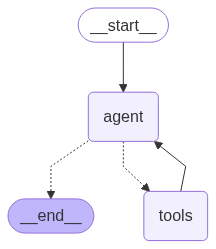

In [10]:
# Visualize the agent graph
try:
    from IPython.display import Image, display
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent graph structure created with:")
    print("- Main agent with planning capabilities")
    print("- File system tools (read, write, edit, ls)")
    print("- Sub-agent spawning capabilities")
    print("- Internet search tool")

## Example: Research Query

Let's start with a research question to see how the deep agent works:

In [11]:
# Simple research query
simple_query = "What is LangGraph and how does it work?"

print(f"Research Query: {simple_query}")
print("\n" + "="*50 + "\n")

# Stream the agent's response
for chunk in agent.stream(
    {"messages": [{"role": "user", "content": simple_query}]},
    stream_mode="values"
):
    if "messages" in chunk:
        chunk["messages"][-1].pretty_print()

Research Query: What is LangGraph and how does it work?


================================ Human Message =================================

What is LangGraph and how does it work?
================================== Ai Message ==================================

I'll help you research LangGraph and how it works. Let me start by recording your question and creating a plan for this research.
Tool Calls:
  write_file (tooluse_ogcBaEGBSAyrDWxQOG1Izg)
 Call ID: tooluse_ogcBaEGBSAyrDWxQOG1Izg
  Args:
    file_path: question.txt
    content: What is LangGraph and how does it work?
================================= Tool Message =================================
Name: write_file

Updated file question.txt
================================== Ai Message ==================================
Tool Calls:
  write_todos (tooluse_4SPfqx1iQdKFurA6S0pobQ)
 Call ID: tooluse_4SPfqx1iQdKFurA6S0pobQ
  Args:
    todos: [{'content': 'Research what LangGraph is - definition, purpose, and overview', 'status': 'pendi

👆 LangSmith Trace: https://smith.langchain.com/public/465ab9f2-2fb1-48ef-bfdc-efaaade11c40/r

## Understanding Deep Agent Components

Let's examine the key components that make this agent "deep":

### 1. Planning Tool
The agent has access to a built-in planning tool that helps it structure complex tasks into manageable steps.

### 2. Sub-Agents
- **Research Agent**: Focuses on gathering information on specific topics
- **Critique Agent**: Reviews and improves the final report
- **General Purpose Agent**: Default sub-agent with same capabilities as main agent

### 3. File System Tools
The agent can:
- `read_file`: Read existing files
- `write_file`: Create new files
- `edit_file`: Modify existing files
- `ls`: List files in the workspace

### 4. Detailed System Prompt
The agent comes with comprehensive instructions for deep reasoning and task execution.

## MCP Integration with OceanBase

Let's integrate the deep agent with OceanBase MCP server for database operations:

In [ ]:
# Install required MCP adapter
!uv pip install -qU langchain-mcp-adapters

In [14]:
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient


In [16]:
# Demo: Get table schema of "test" database
async def demo_get_test_db_schema():
    """Demo function to get table schema of the 'test' database using OceanBase MCP"""
    
    async with MultiServerMCPClient({
        "oceanbase": {
            "url": "http://localhost:8000/sse", 
            "transport": "sse",
        }
    }) as mcp_client:
        # Get OceanBase tools
        oceanbase_tools = mcp_client.get_tools()
        
        # Create agent with OceanBase tools
        agent = create_deep_agent(
            model=model,
            tools=oceanbase_tools,
            instructions="""You are a database expert. Help the user get the table schema for the 'test' database.

Use the available OceanBase tools to:
1. Connect to the database
2. Get the schema information for the 'test' database
3. List all tables and their structures
4. Provide a comprehensive overview of the database schema

Record your findings in a clear, structured format.""",
            subagents=[],  # No sub-agents needed for this demo
        ).with_config({"recursion_limit": 50})
        
        # Query for test database schema
        query = "Please get the table schema for the 'test' database. Show me all tables and their column definitions."
        
        print(f"Demo Query: {query}")
        print("\n" + "="*60 + "\n")
        
        # Stream the agent's response
        async for chunk in agent.astream(
            {"messages": [{"role": "user", "content": query}]},
            stream_mode="values"
        ):
            if "messages" in chunk:
                last_message = chunk["messages"][-1]
                if hasattr(last_message, 'content') and last_message.content:
                    print(f"Agent: {last_message.content}")
                    print("-" * 40)

# Run the demo
print("Demo function created. Run with: await demo_get_test_db_schema()")


Demo function created. Run with: await demo_get_test_db_schema()


In [17]:
# Execute the demo
await demo_get_test_db_schema()


Demo Query: Please get the table schema for the 'test' database. Show me all tables and their column definitions.


Agent: Please get the table schema for the 'test' database. Show me all tables and their column definitions.
----------------------------------------
Agent: I'll help you get the table schema for the 'test' database. Let me break this down into steps and connect to the database to retrieve the schema information.
----------------------------------------
Agent: Updated todo list to [{'content': 'Configure database connection to OceanBase', 'status': 'pending'}, {'content': "Connect to the 'test' database", 'status': 'pending'}, {'content': "Get list of all tables in the 'test' database", 'status': 'pending'}, {'content': 'Get detailed column definitions for each table', 'status': 'pending'}, {'content': 'Format and present the complete schema information', 'status': 'pending'}]
----------------------------------------
Agent: Updated todo list to [{'content': 'Configure dat

👆 LangSmith Trace: https://smith.langchain.com/public/87b3c7b5-1fcf-4967-99bb-3f914c55a017/r

## Key Takeaways - OceanBase MCP Integration

This exercise demonstrated the integration of deep agents with OceanBase through MCP:

1. **MCP Integration**: Successfully connected deep agents to OceanBase MCP server at `localhost:8000/sse`

2. **Simplified Architecture**: Removed unnecessary sub-agents and tools, focusing only on database operations

3. **Database-Specific Instructions**: Customized agent instructions for database schema analysis and querying

4. **Focused Functionality**: Created a specialized agent for database operations rather than general research

5. **Real-time Database Access**: Direct interaction with OceanBase through MCP protocol

## Demo Results

The demo shows how to:
- Connect to OceanBase MCP server
- Get table schema information for the 'test' database
- Use deep agents for structured database analysis
- Maintain workspace files for database findings

## Next Steps

To further explore OceanBase MCP integration with deep agents:

- Expand to query multiple databases
- Add more complex SQL analysis capabilities
- Create database documentation workflows
- Integrate with data visualization tools
- Build database migration and optimization agents

The combination of `deepagents` and `langchain-mcp-adapters` provides a powerful foundation for building database-focused AI agents with persistent workspace capabilities.